[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Fri Jun  6 08:19:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 105.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [6]:
#!wget https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget https://vivre-de-la-photo.fr/wp-content/uploads/2021/12/goh-rhy-yan-f_SDCASisgs-unsplash.jpg
!wget !wget https://vivre-de-la-photo.fr/wp-content/uploads/2021/12/auto-g23f40b856_1280.jpg

--2025-06-06 08:24:29--  https://vivre-de-la-photo.fr/wp-content/uploads/2021/12/goh-rhy-yan-f_SDCASisgs-unsplash.jpg
Resolving vivre-de-la-photo.fr (vivre-de-la-photo.fr)... 193.37.145.81, 2a00:7ee0:1:0:3:2206:0:188
Connecting to vivre-de-la-photo.fr (vivre-de-la-photo.fr)|193.37.145.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 559126 (546K) [image/jpeg]
Saving to: ‘goh-rhy-yan-f_SDCASisgs-unsplash.jpg’

goh-rhy-yan-f_SDCAS 100%[===================>] 546.02K   626KB/s    in 0.9s    

2025-06-06 08:24:31 (626 KB/s) - ‘goh-rhy-yan-f_SDCASisgs-unsplash.jpg’ saved [559126/559126]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

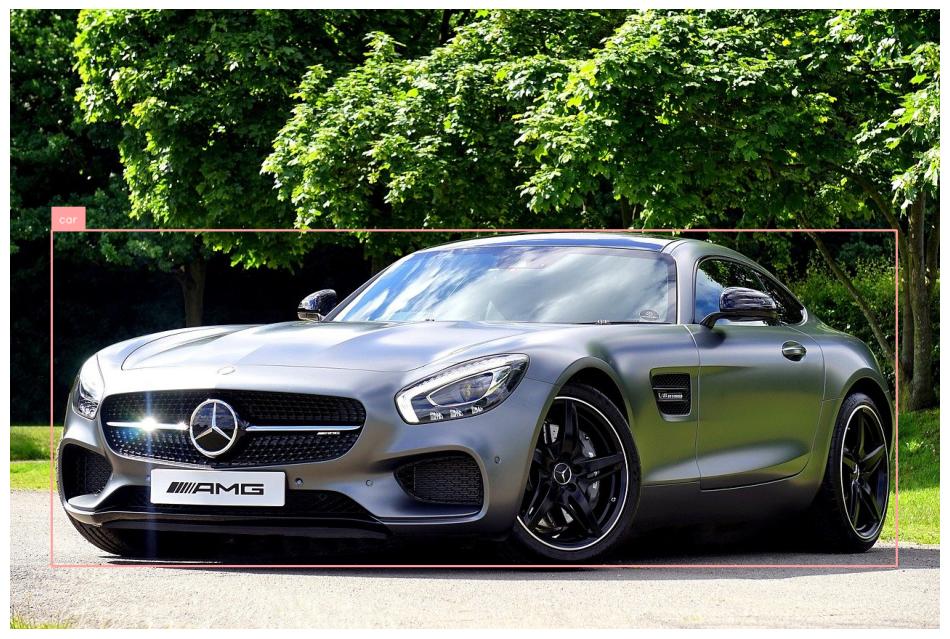

In [40]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/auto-g23f40b856_1280.jpg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [12]:
from roboflow import Roboflow
rf = Roboflow(api_key=os.environ["ROBOFLOW_API_KEY"])
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(11)
dataset = version.download("yolov12")

#from roboflow import download_dataset

#dataset = download_dataset('https://universe.roboflow.com/roboflow-100/circuit-voltages/dataset/2', 'yolov8')
#dataset = download_dataset('https://universe.roboflow.com/ds/fKpZV7d4RP?key=divjgey11E', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-11 in yolov12:: 100%|██████████| 20262/20262 [00:03<00:00, 6159.63it/s]


In [13]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [14]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [15]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['License_Plate']

roboflow:
  workspace: roboflow-universe-projects
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [16]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=25)

New https://pypi.org/project/ultralytics/8.3.151 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/License-Plate-Recognition-11/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None,

100%|██████████| 755k/755k [00:00<00:00, 72.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 12.4MB/s]


AMP: checks passed ✅


train: Scanning /content/License-Plate-Recognition-11/train/labels... 7057 images, 5 backgrounds, 0 corrupt: 100%|██████████| 7057/7057 [00:02<00:00, 2413.69it/s]


train: New cache created: /content/License-Plate-Recognition-11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/License-Plate-Recognition-11/valid/labels... 2048 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2048/2048 [00:02<00:00, 778.73it/s] 


val: New cache created: /content/License-Plate-Recognition-11/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      6.78G      2.586      2.907      2.915          3        640: 100%|██████████| 442/442 [04:08<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:21<00:00,  2.95it/s]

                   all       2048       2195      0.769      0.638      0.702      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      6.91G      1.613      1.164      1.831          2        640: 100%|██████████| 442/442 [04:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.80it/s]

                   all       2048       2195      0.922      0.771      0.857      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      6.75G      1.497     0.9948      1.697          3        640: 100%|██████████| 442/442 [04:06<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2048       2195      0.888       0.79      0.853      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      6.91G      1.412     0.8885      1.607          3        640: 100%|██████████| 442/442 [03:57<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]

                   all       2048       2195      0.945      0.813      0.886      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      6.73G      1.392     0.8293      1.583          1        640: 100%|██████████| 442/442 [04:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:19<00:00,  3.25it/s]

                   all       2048       2195      0.953      0.846      0.912      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      6.75G      1.362     0.8089      1.551          1        640: 100%|██████████| 442/442 [03:55<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:21<00:00,  2.92it/s]

                   all       2048       2195      0.939      0.845      0.912      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       6.9G      1.322     0.7699      1.514          0        640: 100%|██████████| 442/442 [04:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:21<00:00,  2.96it/s]

                   all       2048       2195      0.963      0.866      0.926      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      6.75G      1.293     0.7371      1.492          3        640: 100%|██████████| 442/442 [04:09<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.64it/s]

                   all       2048       2195       0.96      0.865      0.926       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      6.74G       1.29     0.7117      1.485          1        640: 100%|██████████| 442/442 [04:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:21<00:00,  2.94it/s]

                   all       2048       2195      0.957      0.862      0.926      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25       6.9G      1.272     0.6953      1.468          0        640: 100%|██████████| 442/442 [04:09<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:20<00:00,  3.09it/s]

                   all       2048       2195      0.964      0.862      0.927      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       6.9G      1.255     0.6759      1.447          2        640: 100%|██████████| 442/442 [04:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:20<00:00,  3.08it/s]

                   all       2048       2195      0.961      0.883      0.934      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      6.75G      1.242     0.6709      1.442          2        640: 100%|██████████| 442/442 [04:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:20<00:00,  3.16it/s]

                   all       2048       2195      0.972      0.888      0.939      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      6.74G      1.222     0.6382      1.423          1        640: 100%|██████████| 442/442 [04:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:28<00:00,  2.26it/s]

                   all       2048       2195      0.973      0.901      0.946      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      6.75G      1.212     0.6298      1.416          0        640: 100%|██████████| 442/442 [04:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:20<00:00,  3.15it/s]

                   all       2048       2195      0.971      0.895      0.943      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      6.74G      1.207     0.6256      1.407          1        640: 100%|██████████| 442/442 [04:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:18<00:00,  3.37it/s]

                   all       2048       2195      0.969      0.897      0.945      0.641


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      6.75G      1.175     0.5592      1.481          1        640: 100%|██████████| 442/442 [03:57<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:19<00:00,  3.36it/s]

                   all       2048       2195      0.978      0.884      0.943      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      6.74G      1.153     0.5379      1.464          1        640: 100%|██████████| 442/442 [03:55<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:19<00:00,  3.25it/s]

                   all       2048       2195      0.972      0.907      0.952      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      6.75G      1.146     0.5228      1.452          1        640: 100%|██████████| 442/442 [03:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:19<00:00,  3.23it/s]

                   all       2048       2195      0.965      0.912      0.953      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      6.73G      1.126     0.5128      1.437          1        640: 100%|██████████| 442/442 [03:55<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:19<00:00,  3.27it/s]

                   all       2048       2195      0.969      0.911      0.953      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      6.74G      1.126     0.5057       1.43          1        640: 100%|██████████| 442/442 [03:57<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:20<00:00,  3.13it/s]

                   all       2048       2195      0.969       0.91      0.951       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       6.9G      1.116     0.4965      1.434          1        640: 100%|██████████| 442/442 [04:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:19<00:00,  3.31it/s]

                   all       2048       2195      0.974      0.913      0.954      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      6.74G      1.105     0.4848       1.42          1        640: 100%|██████████| 442/442 [04:04<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:19<00:00,  3.26it/s]

                   all       2048       2195      0.967      0.922      0.956      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       6.9G       1.09     0.4774      1.406          1        640: 100%|██████████| 442/442 [03:56<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:20<00:00,  3.05it/s]

                   all       2048       2195      0.973      0.923      0.958      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      6.74G      1.083     0.4666      1.397          1        640: 100%|██████████| 442/442 [03:55<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:20<00:00,  3.13it/s]

                   all       2048       2195      0.971      0.916      0.957      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       6.9G      1.074     0.4653      1.387          1        640: 100%|██████████| 442/442 [03:56<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:20<00:00,  3.12it/s]

                   all       2048       2195      0.981      0.915      0.959      0.677



25 epochs completed in 1.839 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:20<00:00,  3.06it/s]


                   all       2048       2195      0.971      0.916      0.957      0.678
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [17]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch1.jpg
confusion_matrix_normalized.png			   train_batch2.jpg
confusion_matrix.png				   train_batch6630.jpg
events.out.tfevents.1749198741.cd26162bb49b.772.0  train_batch6631.jpg
F1_curve.png					   train_batch6632.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


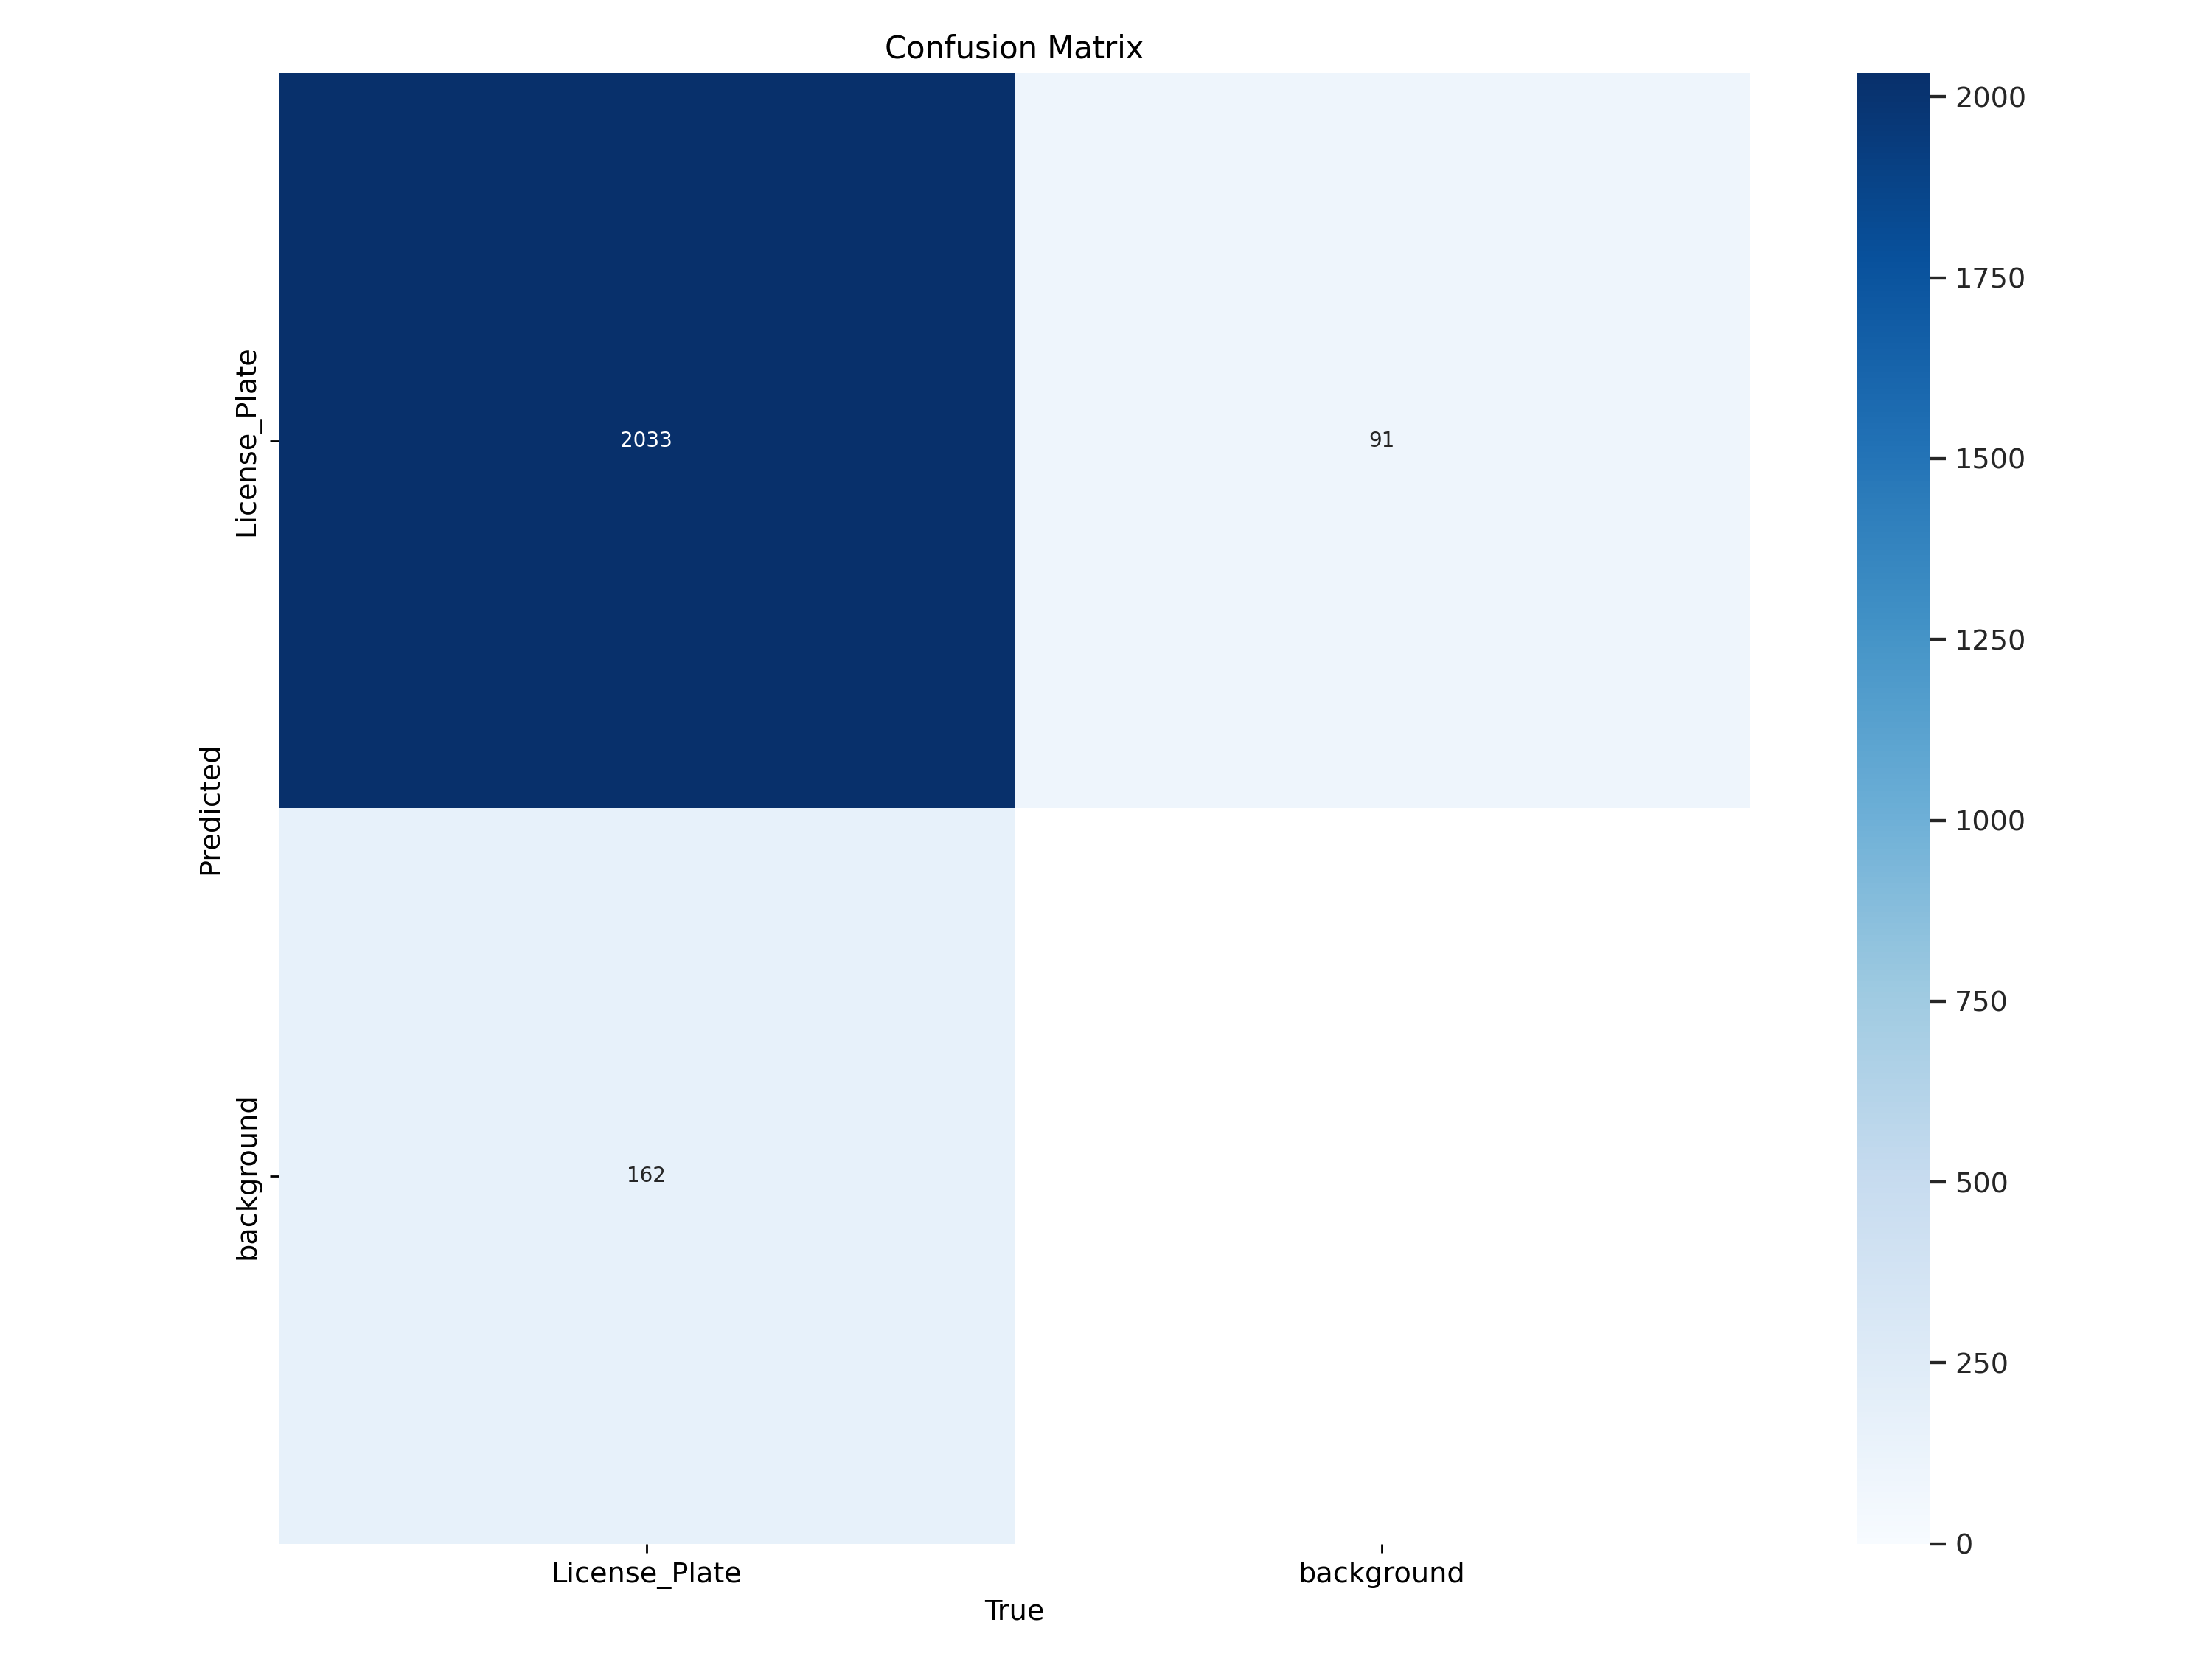

In [18]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

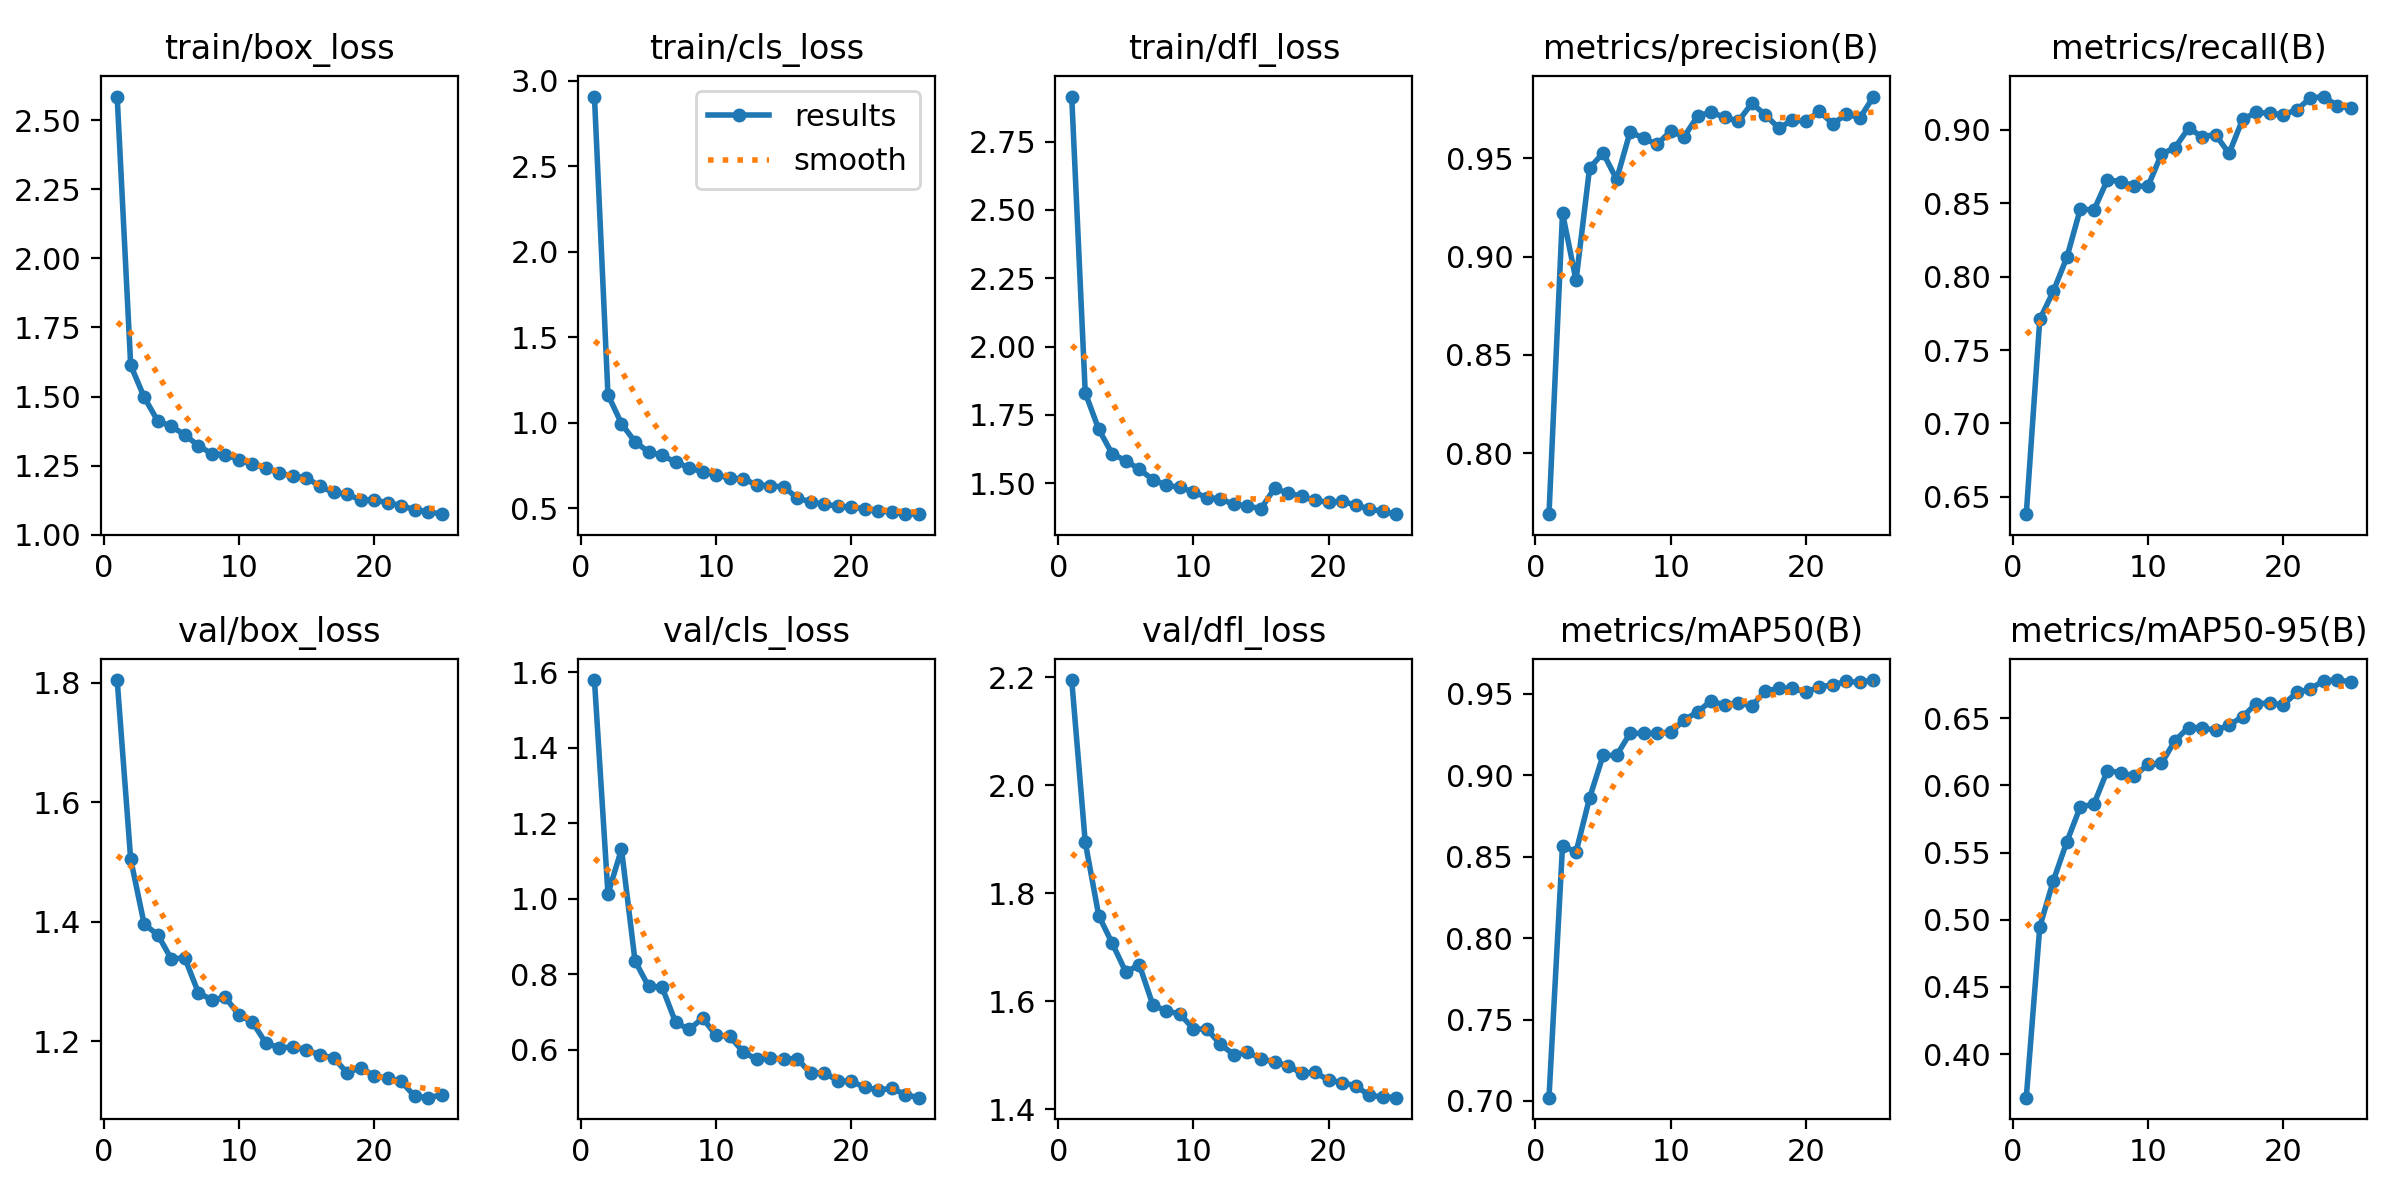

In [19]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [20]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['License_Plate']

In [21]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [22]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6449012612527917
mAP 50 0.9201568124763634
mAP 75 0.7655717348741884


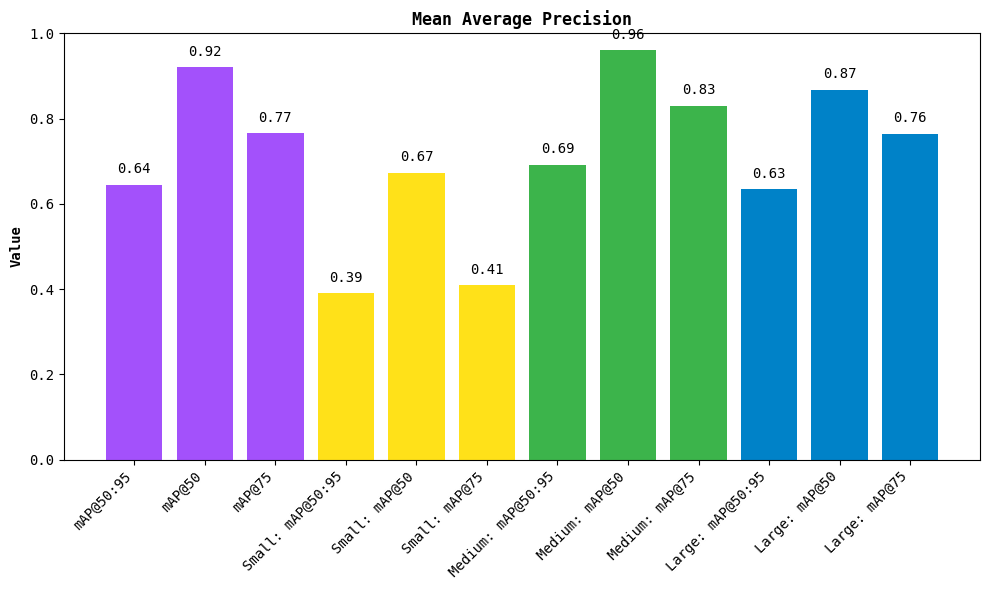

In [23]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [24]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

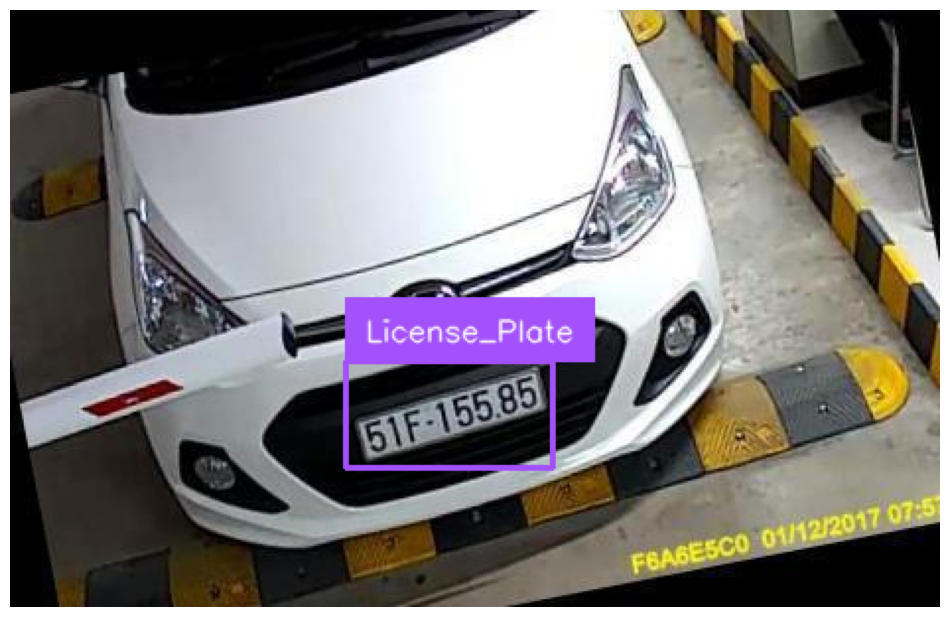

In [37]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

--2025-06-06 10:38:55--  https://vivre-de-la-photo.fr/wp-content/uploads/2021/12/auto-g23f40b856_1280.jpg
Resolving vivre-de-la-photo.fr (vivre-de-la-photo.fr)... 193.37.145.81, 2a00:7ee0:1:0:3:2206:0:188
Connecting to vivre-de-la-photo.fr (vivre-de-la-photo.fr)|193.37.145.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364649 (356K) [image/jpeg]
Saving to: ‘auto-g23f40b856_1280.jpg’

auto-g23f40b856_128 100%[===================>] 356.10K   465KB/s    in 0.8s    

2025-06-06 10:38:57 (465 KB/s) - ‘auto-g23f40b856_1280.jpg’ saved [364649/364649]



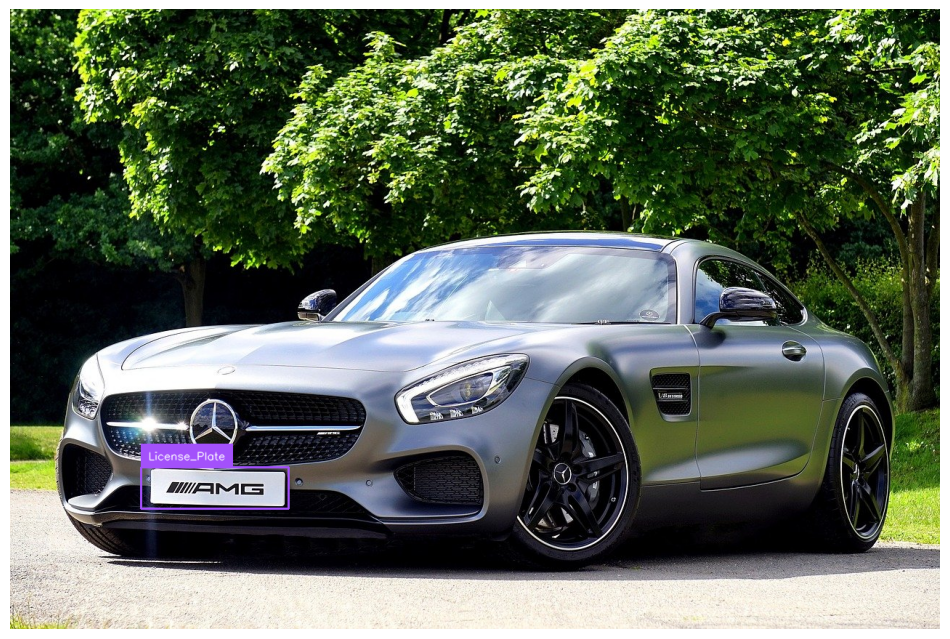

In [39]:
model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

!wget https://vivre-de-la-photo.fr/wp-content/uploads/2021/12/auto-g23f40b856_1280.jpg

image_path = f"{HOME}/auto-g23f40b856_1280.jpg"
image = cv2.imread(image_path)

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)